***
Welcome! 

In this notebook we are going to use a data science model to represent our words as vectors. This will be similar to what we have done in the `co-ocurrence` lectures, but we are going to Word2Vec tohelp us to obtain our vectors by using a training process in a Neural Network.
<br>
<br>
This is a similar implementation to what is shown in the paper (Particularly the `Continuous Bag of Words Model`):
- https://arxiv.org/pdf/1301.3781.pdf
***

In [1]:
from nltk.tokenize import word_tokenize

import numpy as np

Let's start small, with a simple sentence:

In [2]:
sentence = 'I went to the library because I love to read'

First step, our usual pre-processing - turning a sentence into tokenized format:

In [4]:
tokenized_sentence = word_tokenize(sentence.lower())

In [4]:
tokenized_sentence

['i', 'went', 'to', 'the', 'library', 'because', 'i', 'love', 'to', 'read']

To feed our machine learning model, we need to build a similar framework to what we have done in the past lecture - a sliding window of neighbour words:

**A simple example of what we want:**

In [16]:
neighbors = 2

# Loop through our words in the tokenized sentence
for index, word in enumerate(tokenized_sentence):
    
    # Build a start index to check the context
    start = max(0, index - neighbors)
    # Build a last index to check the context
    # Again, we have to pay attention if the neighbors overflow
    # the index so that we only go until the last position of the
    # sentence
    finish = min(len(tokenized_sentence), index + neighbors + 1)
    # Print our examples, for now
    print(word, tokenized_sentence[start:finish+1])
    

i ['i', 'went', 'to', 'the']
went ['i', 'went', 'to', 'the', 'library']
to ['i', 'went', 'to', 'the', 'library', 'because']
the ['went', 'to', 'the', 'library', 'because', 'i']
library ['to', 'the', 'library', 'because', 'i', 'love']
because ['the', 'library', 'because', 'i', 'love', 'to']
i ['library', 'because', 'i', 'love', 'to', 'read']
love ['because', 'i', 'love', 'to', 'read']
to ['i', 'love', 'to', 'read']
read ['love', 'to', 'read']


We only want words that have all surrounding words available so for example:
- `i` only has `went` and `to` on it's neighbourhood - fewer examples than the total neighbor window (2+2)
- `read` also has only two neighbour instances as it finishes the sentence.

Let's create our training_data based on those rules (and additionally, we will also remove the center word from the context):

In [17]:
# Building our training set
training_data = {}

# Doing the same but with a slightly different
# implementation to remove the context word
# and only consider examples where we have 2*neighbour window
for index, word in enumerate(tokenized_sentence):
    if (index < neighbors) or (len(tokenized_sentence)-index < neighbors+1):
        continue
    else:  
        start = index-neighbors        
        finish = index+neighbors
        
        neighbor_words = tokenized_sentence[start:finish+1]
        
        print(word, neighbor_words[:neighbors]+neighbor_words[neighbors+1:])
        
        training_data[word] = neighbor_words[:neighbors]+neighbor_words[neighbors+1:]
    

to ['i', 'went', 'the', 'library']
the ['went', 'to', 'library', 'because']
library ['to', 'the', 'because', 'i']
because ['the', 'library', 'i', 'love']
i ['library', 'because', 'love', 'to']
love ['because', 'i', 'to', 'read']


In [18]:
# Now let's create a map of each word to our vocabulary:
vocab = list(set(tokenized_sentence))
vocab.sort()

In [20]:
# Let's also turn this into a dictionary to make it more clear:
vocab_dict = {}

for index, item in enumerate(vocab):
    vocab_dict[item] = index

In [21]:
vocab_dict

{'because': 0,
 'i': 1,
 'library': 2,
 'love': 3,
 'read': 4,
 'the': 5,
 'to': 6,
 'went': 7}

We have a dictionary that maps our words into a vocabulary - now let's turn our `training_data` into a vector.

In [22]:
training_data

{'to': ['i', 'went', 'the', 'library'],
 'the': ['went', 'to', 'library', 'because'],
 'library': ['to', 'the', 'because', 'i'],
 'because': ['the', 'library', 'i', 'love'],
 'i': ['library', 'because', 'love', 'to'],
 'love': ['because', 'i', 'to', 'read']}

If we check the word **"to"** - it is our 7th word in the vocab, if we put it in a one-hot vector format (vectors again!):

-> `[0, 0, 0, 0, 0, 0, 1, 0]`

The word **to** is surrounded by the words *i* , *went* , *the* and *library*. In bold, we have our target word - in italic we have our context words - the context words can be represented by:

*i* -> `[0, 1, 0, 0, 0, 0, 0]`
<br>
*went* -> `[0, 0, 0, 0, 0, 0, 1]`
<br>
*the* -> `[0, 0, 0, 0, 1, 0, 0]`
<br>
*library* -> `[0, 0, 1, 0, 0, 0, 0]`

A simple operation to crunch these arrays into a single one would be to apply a mean on the 4 arrays, that would lead to:
<br>
*array_neighbors* -> `[0, 0.25, 0, 0.25, 0.25, 0, 0.25]`

Let's build this in code!

In [23]:
vocab_arrays = {}

for word, column_index in vocab_dict.items():
    word_array = np.zeros((1, len(vocab_dict)))
    word_array[0, column_index] = 1
    vocab_arrays[word] = word_array

In [25]:
vocab_arrays

{'because': array([[1., 0., 0., 0., 0., 0., 0., 0.]]),
 'i': array([[0., 1., 0., 0., 0., 0., 0., 0.]]),
 'library': array([[0., 0., 1., 0., 0., 0., 0., 0.]]),
 'love': array([[0., 0., 0., 1., 0., 0., 0., 0.]]),
 'read': array([[0., 0., 0., 0., 1., 0., 0., 0.]]),
 'the': array([[0., 0., 0., 0., 0., 1., 0., 0.]]),
 'to': array([[0., 0., 0., 0., 0., 0., 1., 0.]]),
 'went': array([[0., 0., 0., 0., 0., 0., 0., 1.]])}

In [13]:
# And now creating our examples of Training by averaging
# The vectors of each word in the context

word_size = len(vocab_dict)
training_size = len(training_data.items())

y = np.zeros([training_size, word_size])
X = np.zeros([training_size, word_size])

for index, train in enumerate(training_data.items()):
    
    word = train[0]
    y[index,:] = vocab_arrays[word]
    
    aux_array = np.zeros([1, word_size])
    
    for neighbour in train[1]:
        aux_array = aux_array+vocab_arrays[neighbour]
        
    X[index,:] = aux_array/(neighbors*2)
    
    

In [14]:
X

array([[0.  , 0.25, 0.25, 0.  , 0.  , 0.25, 0.  , 0.25],
       [0.25, 0.  , 0.25, 0.  , 0.  , 0.  , 0.25, 0.25],
       [0.25, 0.25, 0.  , 0.  , 0.  , 0.25, 0.25, 0.  ],
       [0.  , 0.25, 0.25, 0.25, 0.  , 0.25, 0.  , 0.  ],
       [0.25, 0.  , 0.25, 0.25, 0.  , 0.  , 0.25, 0.  ],
       [0.25, 0.25, 0.  , 0.  , 0.25, 0.  , 0.25, 0.  ]])

In [15]:
y

array([[0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.]])

- **X arrays are the features - the data we will use to try to predict the y's**. 
- Most machine learning models work this way - you try to use some variables that will be used to predict some event y (the event y can be continuous or classes).
- The most simple example you can think of is building a model that tries to guess someone's weight based on their height.
- The machine learning model learns by knowing more and more examples of the features **X** and the target **y** - it does that mathematically by updating the weights that gives to each variable when making the final call.

The diagram below shows how most models learn:
    - The Cost is the error, generally a function that maps how right or wrong your algorithm is.
    - The Weight is the value that you give to each variable. 

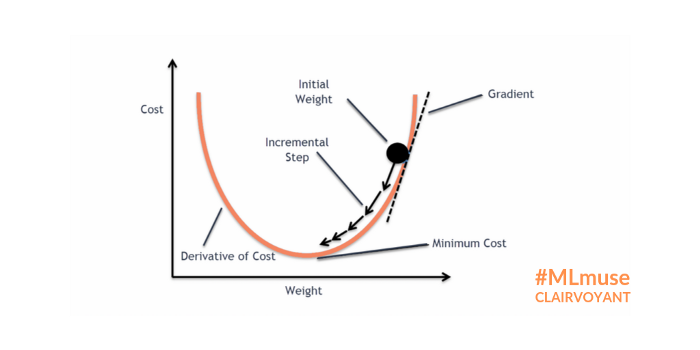

Source: https://blog.clairvoyantsoft.com/the-ascent-of-gradient-descent-23356390836f

To estimate these weights, there are multiple techniques that will help you - the most simple one is linear regression that lets you map a line that gives you a prediction for variable y given feature x:

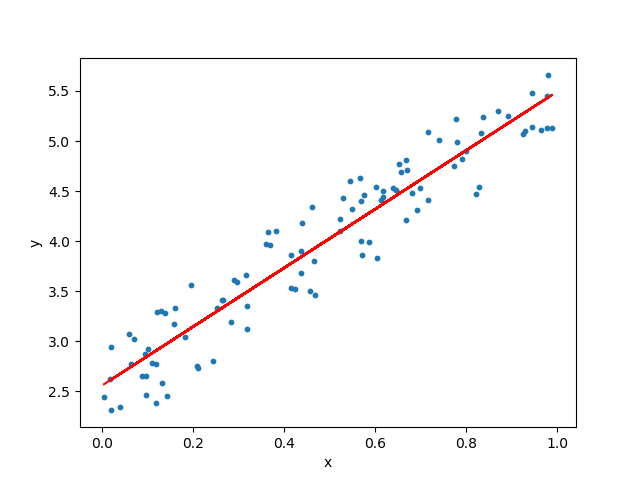

The CBOW model uses a more advanced model to estimate the weights - called a **Neural Network**:

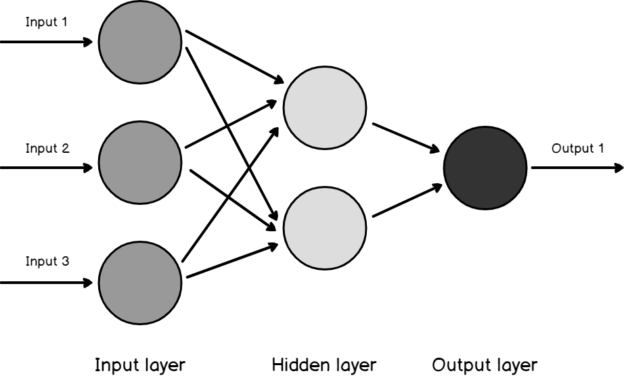

Source: https://www.sqlshack.com/implement-artificial-neural-networks-anns-in-sql-server/

Let's implement a Simple Neural Network using keras (a neat library that let us build a neural network really fast - this library is an API that bases on the Tensorflow framework (https://en.wikipedia.org/wiki/TensorFlow)):

In [16]:
from keras.models import Sequential
from keras.layers import Dense

In [17]:
# Building model architecture
model = Sequential()
# Adding the hidden layer
model.add(Dense(4, input_dim=word_size, activation='relu'))
# Adding the output layer
model.add(Dense(word_size, input_dim=4, activation='softmax'))

# Compiling the network
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

Let's train our model for 1000 epochs - 1 epoch is equal to our neural network seeing all our examples in the training base 1 time.

In [18]:
# Fitting our model, let's train for 1000
# epochs
model.fit(X, y, epochs=1000)

Epoch 1/1000
1/1 [==============================] - 0s 4ms/step - loss: 2.1018 - accuracy: 0.1667
Epoch 2/1000
1/1 [==============================] - 0s 2ms/step - loss: 2.1007 - accuracy: 0.1667
Epoch 3/1000
1/1 [==============================] - 0s 2ms/step - loss: 2.0996 - accuracy: 0.1667
Epoch 4/1000
1/1 [==============================] - 0s 3ms/step - loss: 2.0985 - accuracy: 0.1667
Epoch 5/1000
1/1 [==============================] - 0s 3ms/step - loss: 2.0974 - accuracy: 0.1667
Epoch 6/1000
1/1 [==============================] - 0s 2ms/step - loss: 2.0963 - accuracy: 0.1667
Epoch 7/1000
1/1 [==============================] - 0s 2ms/step - loss: 2.0952 - accuracy: 0.1667
Epoch 8/1000
1/1 [==============================] - 0s 3ms/step - loss: 2.0941 - accuracy: 0.1667
Epoch 9/1000
1/1 [==============================] - 0s 2ms/step - loss: 2.0930 - accuracy: 0.1667
Epoch 10/1000
1/1 [==============================] - 0s 3ms/step - loss: 2.0919 - accuracy: 0.1667
Epoch 11/1000
1/1 [

1/1 [==============================] - 0s 998us/step - loss: 1.9109 - accuracy: 0.3333
Epoch 166/1000
1/1 [==============================] - 0s 997us/step - loss: 1.9097 - accuracy: 0.3333
Epoch 167/1000
1/1 [==============================] - 0s 2ms/step - loss: 1.9085 - accuracy: 0.3333
Epoch 168/1000
1/1 [==============================] - 0s 3ms/step - loss: 1.9073 - accuracy: 0.3333
Epoch 169/1000
1/1 [==============================] - 0s 3ms/step - loss: 1.9061 - accuracy: 0.3333
Epoch 170/1000
1/1 [==============================] - 0s 1000us/step - loss: 1.9049 - accuracy: 0.3333
Epoch 171/1000
1/1 [==============================] - 0s 3ms/step - loss: 1.9037 - accuracy: 0.3333
Epoch 172/1000
1/1 [==============================] - 0s 3ms/step - loss: 1.9025 - accuracy: 0.3333
Epoch 173/1000
1/1 [==============================] - 0s 3ms/step - loss: 1.9013 - accuracy: 0.3333
Epoch 174/1000
1/1 [==============================] - 0s 3ms/step - loss: 1.9001 - accuracy: 0.3333
Epoch 17

1/1 [==============================] - 0s 4ms/step - loss: 1.7158 - accuracy: 0.5000
Epoch 329/1000
1/1 [==============================] - 0s 2ms/step - loss: 1.7146 - accuracy: 0.5000
Epoch 330/1000
1/1 [==============================] - 0s 3ms/step - loss: 1.7135 - accuracy: 0.5000
Epoch 331/1000
1/1 [==============================] - 0s 3ms/step - loss: 1.7123 - accuracy: 0.5000
Epoch 332/1000
1/1 [==============================] - 0s 3ms/step - loss: 1.7111 - accuracy: 0.5000
Epoch 333/1000
1/1 [==============================] - 0s 5ms/step - loss: 1.7100 - accuracy: 0.5000
Epoch 334/1000
1/1 [==============================] - 0s 3ms/step - loss: 1.7088 - accuracy: 0.5000
Epoch 335/1000
1/1 [==============================] - 0s 4ms/step - loss: 1.7077 - accuracy: 0.5000
Epoch 336/1000
1/1 [==============================] - 0s 5ms/step - loss: 1.7065 - accuracy: 0.5000
Epoch 337/1000
1/1 [==============================] - 0s 3ms/step - loss: 1.7053 - accuracy: 0.5000
Epoch 338/1000


1/1 [==============================] - 0s 966us/step - loss: 1.6224 - accuracy: 0.5000
Epoch 411/1000
1/1 [==============================] - 0s 3ms/step - loss: 1.6213 - accuracy: 0.5000
Epoch 412/1000
1/1 [==============================] - 0s 2ms/step - loss: 1.6202 - accuracy: 0.5000
Epoch 413/1000
1/1 [==============================] - 0s 3ms/step - loss: 1.6191 - accuracy: 0.3333
Epoch 414/1000
1/1 [==============================] - 0s 2ms/step - loss: 1.6180 - accuracy: 0.3333
Epoch 415/1000
1/1 [==============================] - 0s 4ms/step - loss: 1.6169 - accuracy: 0.3333
Epoch 416/1000
1/1 [==============================] - 0s 2ms/step - loss: 1.6157 - accuracy: 0.3333
Epoch 417/1000
1/1 [==============================] - 0s 3ms/step - loss: 1.6146 - accuracy: 0.3333
Epoch 418/1000
1/1 [==============================] - 0s 2ms/step - loss: 1.6135 - accuracy: 0.3333
Epoch 419/1000
1/1 [==============================] - 0s 2ms/step - loss: 1.6124 - accuracy: 0.3333
Epoch 420/100

1/1 [==============================] - 0s 2ms/step - loss: 1.5345 - accuracy: 0.5000
Epoch 493/1000
1/1 [==============================] - 0s 2ms/step - loss: 1.5335 - accuracy: 0.5000
Epoch 494/1000
1/1 [==============================] - 0s 2ms/step - loss: 1.5324 - accuracy: 0.5000
Epoch 495/1000
1/1 [==============================] - 0s 2ms/step - loss: 1.5314 - accuracy: 0.5000
Epoch 496/1000
1/1 [==============================] - 0s 2ms/step - loss: 1.5304 - accuracy: 0.5000
Epoch 497/1000
1/1 [==============================] - 0s 4ms/step - loss: 1.5294 - accuracy: 0.5000
Epoch 498/1000
1/1 [==============================] - 0s 2ms/step - loss: 1.5283 - accuracy: 0.5000
Epoch 499/1000
1/1 [==============================] - 0s 2ms/step - loss: 1.5273 - accuracy: 0.5000
Epoch 500/1000
1/1 [==============================] - 0s 2ms/step - loss: 1.5263 - accuracy: 0.5000
Epoch 501/1000
1/1 [==============================] - 0s 2ms/step - loss: 1.5252 - accuracy: 0.5000
Epoch 502/1000


1/1 [==============================] - 0s 991us/step - loss: 1.3795 - accuracy: 0.5000
Epoch 656/1000
1/1 [==============================] - 0s 2ms/step - loss: 1.3787 - accuracy: 0.5000
Epoch 657/1000
1/1 [==============================] - 0s 1ms/step - loss: 1.3778 - accuracy: 0.5000
Epoch 658/1000
1/1 [==============================] - 0s 3ms/step - loss: 1.3770 - accuracy: 0.5000
Epoch 659/1000
1/1 [==============================] - 0s 3ms/step - loss: 1.3762 - accuracy: 0.5000
Epoch 660/1000
1/1 [==============================] - 0s 3ms/step - loss: 1.3753 - accuracy: 0.5000
Epoch 661/1000
1/1 [==============================] - 0s 2ms/step - loss: 1.3745 - accuracy: 0.5000
Epoch 662/1000
1/1 [==============================] - 0s 2ms/step - loss: 1.3736 - accuracy: 0.5000
Epoch 663/1000
1/1 [==============================] - 0s 2ms/step - loss: 1.3728 - accuracy: 0.5000
Epoch 664/1000
1/1 [==============================] - 0s 2ms/step - loss: 1.3719 - accuracy: 0.5000
Epoch 665/100

Epoch 818/1000
1/1 [==============================] - 0s 3ms/step - loss: 1.2506 - accuracy: 0.6667
Epoch 819/1000
1/1 [==============================] - 0s 2ms/step - loss: 1.2498 - accuracy: 0.6667
Epoch 820/1000
1/1 [==============================] - 0s 999us/step - loss: 1.2491 - accuracy: 0.6667
Epoch 821/1000
1/1 [==============================] - 0s 2ms/step - loss: 1.2483 - accuracy: 0.6667
Epoch 822/1000
1/1 [==============================] - 0s 3ms/step - loss: 1.2476 - accuracy: 0.6667
Epoch 823/1000
1/1 [==============================] - 0s 3ms/step - loss: 1.2468 - accuracy: 0.6667
Epoch 824/1000
1/1 [==============================] - 0s 997us/step - loss: 1.2461 - accuracy: 0.6667
Epoch 825/1000
1/1 [==============================] - 0s 2ms/step - loss: 1.2454 - accuracy: 0.6667
Epoch 826/1000
1/1 [==============================] - 0s 4ms/step - loss: 1.2446 - accuracy: 0.6667
Epoch 827/1000
1/1 [==============================] - 0s 3ms/step - loss: 1.2439 - accuracy: 0.6

1/1 [==============================] - 0s 2ms/step - loss: 1.1356 - accuracy: 0.6667
Epoch 981/1000
1/1 [==============================] - 0s 2ms/step - loss: 1.1349 - accuracy: 0.6667
Epoch 982/1000
1/1 [==============================] - 0s 1ms/step - loss: 1.1343 - accuracy: 0.6667
Epoch 983/1000
1/1 [==============================] - 0s 3ms/step - loss: 1.1336 - accuracy: 0.8333
Epoch 984/1000
1/1 [==============================] - 0s 2ms/step - loss: 1.1329 - accuracy: 0.8333
Epoch 985/1000
1/1 [==============================] - 0s 1ms/step - loss: 1.1323 - accuracy: 0.8333
Epoch 986/1000
1/1 [==============================] - 0s 2ms/step - loss: 1.1316 - accuracy: 0.8333
Epoch 987/1000
1/1 [==============================] - 0s 3ms/step - loss: 1.1309 - accuracy: 0.8333
Epoch 988/1000
1/1 [==============================] - 0s 2ms/step - loss: 1.1302 - accuracy: 0.8333
Epoch 989/1000
1/1 [==============================] - 0s 3ms/step - loss: 1.1296 - accuracy: 0.8333
Epoch 990/1000


In [19]:
# The predict method let us get the predicted word
# for each context
model.predict(X)

array([[0.38175082, 0.00357986, 0.1417779 , 0.0100978 , 0.0118779 ,
        0.01679325, 0.4295803 , 0.0045422 ],
       [0.05522546, 0.18068542, 0.1564457 , 0.22328547, 0.04558019,
        0.22162257, 0.07632838, 0.04082671],
       [0.07706814, 0.03624029, 0.45550063, 0.08403517, 0.02802121,
        0.09713586, 0.20535979, 0.01663892],
       [0.5065456 , 0.00497384, 0.07838537, 0.01112784, 0.01366347,
        0.01865027, 0.36094573, 0.0057078 ],
       [0.0496394 , 0.24370427, 0.08682888, 0.24299262, 0.04570764,
        0.23463498, 0.05051199, 0.04598026],
       [0.05522553, 0.18068437, 0.1564472 , 0.223285  , 0.04558016,
        0.22162223, 0.07632888, 0.04082661]], dtype=float32)

In [20]:
# Storing the prediction
prediction = model.predict(X)

In [21]:
# Selecting as 1 for the word that has
# the highest value in the prediction
for index, element in enumerate(prediction):
    predicted = element.argmax()
    prediction[index,:] = 0 
    prediction[index, predicted] = 1

The prediction from our model is stores in the object named `prediction`:

In [22]:
# Now our prediction is a binary vector of 1's and 0's
# just like our vocab vector
prediction

array([[0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.]], dtype=float32)

Let's check what word our model predicts as the center word given the surrounding words:

In [23]:
for index, sentence in enumerate(training_data.items()):
    print('For sentence: '+' '.join(sentence[1][0:2])+' '+' '.join(sentence[1][2:]))
    predicted_word = prediction[index]
    
    # Store keys and values from our dictionary
    for word, array_val in vocab_arrays.items():
        if np.array_equal(array_val[0], predicted_word):
            print('The center word predicted is: '+word)

For sentence: i went the library
The center word predicted is: to
For sentence: went to library because
The center word predicted is: love
For sentence: to the because i
The center word predicted is: library
For sentence: the library i love
The center word predicted is: because
For sentence: library because love to
The center word predicted is: i
For sentence: because i to read
The center word predicted is: love


But.. where are the **embeddings** (our numeric representation of words), actually?
<br>
<br>
Remember the middle layer on our Neural Network? **It has some weights as input and output!**

In [24]:
embeddings = [layer.get_weights() for layer in model.layers]

Embeddings are stored in the weights of the Neural Network!

In [25]:
embeddings_layer = embeddings[0][0]
embeddings_layer_2 = embeddings[1][0]

First example of embeddings:

In [26]:
embeddings_layer

array([[-0.6121875 , -1.6370385 , -0.7498074 , -0.51996636],
       [-0.13055325,  1.4123995 ,  1.7167205 ,  0.02554858],
       [-0.5258878 ,  0.9533414 , -0.11927561,  0.2643388 ],
       [-0.5995194 ,  0.65738016, -0.4219933 ,  0.00593662],
       [-0.3649047 , -0.229158  , -1.1569752 ,  0.13026273],
       [ 0.23932546,  1.1842957 ,  1.8733184 , -0.3777536 ],
       [ 0.17284   , -1.9284545 ,  0.29299226, -0.31532502],
       [-0.02115184,  0.14170162,  0.67900306, -0.6238858 ]],
      dtype=float32)

Second example of Embeddings:

In [27]:
embeddings_layer_2.T

array([[ 0.14534259,  1.6960231 ,  0.3404495 ,  0.01358491],
       [ 0.16214615, -1.3195052 , -1.2391449 ,  0.49978608],
       [ 0.11954767, -1.0883005 ,  2.2169921 , -0.6193103 ],
       [ 0.47115594, -1.3335452 , -0.40381116,  0.5404964 ],
       [ 0.06493294, -0.32101303, -0.08547778,  0.48868507],
       [ 0.555932  , -1.0446873 , -0.29667956,  0.58801085],
       [-0.1920883 ,  0.69622064,  1.5322175 , -0.10738122],
       [-0.12447602, -0.60014665, -0.53729564,  0.42230433]],
      dtype=float32)

In [28]:
vocab_dict

{'because': 0,
 'i': 1,
 'library': 2,
 'love': 3,
 'read': 4,
 'the': 5,
 'to': 6,
 'went': 7}

Now, let's see the embedding for the word "library" stored in the first layer:

In [29]:
embeddings_layer[2]

array([-0.5258878 ,  0.9533414 , -0.11927561,  0.2643388 ], dtype=float32)

And the word "read":

In [30]:
embeddings_layer[4]

array([-0.3649047 , -0.229158  , -1.1569752 ,  0.13026273], dtype=float32)

One common method to combine embeddings is to simple average both arrays:

In [31]:
(embeddings_layer_2.T+embeddings_layer)/2

array([[-0.23342246,  0.02949232, -0.20467895, -0.25319073],
       [ 0.01579645,  0.04644716,  0.23878777,  0.26266733],
       [-0.20317006, -0.06747952,  1.0488583 , -0.17748576],
       [-0.06418172, -0.33808252, -0.41290224,  0.27321652],
       [-0.14998588, -0.2750855 , -0.6212265 ,  0.3094739 ],
       [ 0.39762872,  0.06980419,  0.78831947,  0.10512863],
       [-0.00962415, -0.61611694,  0.91260487, -0.21135312],
       [-0.07281393, -0.2292225 ,  0.07085371, -0.10079074]],
      dtype=float32)

In the next lecture, we will use the same process in a large portion of text that we will get from Wikipedia and check our word similarities. Hopefully, these similarities are more meaningful as we train the word embeddings on more text!
<br>